<a href="https://colab.research.google.com/github/ebernatene/faire-ai/blob/main/notebooks/FAIRE-AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ``faire.ai’s Data scientist case study``

![title](https://media-exp1.licdn.com/dms/image/C4E1BAQE8QiDVN5-7Ug/company-background_10000/0/1600070842318?e=2159024400&v=beta&t=nDy80t4g5XUry_JP1xbSXRkXayKhq52HlHrFxIDP3uo)

# Syntetic Data Points 

Defino la clase ``SyntheticData`` para crear conjuntos de datos sintéticos. Cada punto que se genera contiene los features "age", "sex", "purchase" y "output" con distribuciones de valores acordes a los requerimientos solicitados. 
Para asegurar la reproducción de los resultados es necesario establecer un valor para ``seed`` el cual inicializará el estado aleatorio.

In [1]:
from numpy import random 
import pandas as pd


class SyntheticData:
  def __init__(self, seed):
    random.seed(seed)
            
  def generate_dataset(self, n):
    dataset = pd.DataFrame(columns=['sex','age','purchase','output'])
    dataset['sex'] = random.random(size=n)<0.4
    dataset['sex'] = dataset['sex'].astype(int)
    dataset['age'] = random.gamma(shape=8, scale=4, size=n)
    dataset['age'] = dataset['age'].astype(int)
    dataset['purchase'] = dataset.apply(lambda x: self.__purchase(x['age']),axis=1)
    dataset['output'] = dataset.apply(lambda x: self.__output(x['sex'],x['age'],x['purchase']),axis=1)
    dataset['output'] = dataset['output'].astype(int)
    return dataset

  def __purchase(self, age):
    return round(float(random.uniform(500,550,1)-10*age*random.uniform(-2,0.01,1)),2)
        
  def __output(self, sex, age, purchase):
    prob = 0.3*sex+(0.2 if age>30 else 0.4)+(0.3 if purchase>100 else 0)
    return int(random.random(size=1)<prob)

Haciendo uso del generador de datos se construye un conjunto de datos de 5k puntos. Para esto defino ``SEED=123``, el cual será utilizado a lo largo de todo el notebook en donde deba definir un estado aleatorio.

In [2]:
SEED = 123

gen = SyntheticData(SEED)
data = gen.generate_dataset(5000)

data.head()

,sex,age,purchase,output
0,0,16,765.80,0
1,1,33,1013.33,1
2,1,67,1030.11,0
3,0,28,683.88,1
4,0,44,1237.71,0


# Exploratorio 

Antes de iniciar el trabajo revisaré algunos aspectos mínimos del conjunto de datos generados a modo de chequeo. Primero compruebo que no hay valores de ``NULL``. Segundo, que la proporción en el feature "sex" es consistente con una distribución ``Bernoulli(p=0.4)``. Tercero, que la distribución del feature "age" es consistente con una distribución ``Gamma(alpha=8, theta=4)``. Aquí no quiero hacer ningún analisis riguroso, simplemente una rápida inspección visual con el fin de ganar confianza sobre el generador de funciones.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gamma
import numpy as np

sns.set_style("whitegrid")
%matplotlib inline

In [4]:
# Check!
print("Quantity of NULL values")
print("---"*10)
print(data.isnull().sum())

Quantity of NULL values
------------------------------
sex         0
age         0
purchase    0
output      0
dtype: int64


In [5]:
print('Quantity by Sex:')
print("---"*10)
print(data['sex'].value_counts())

Quantity by Sex:
------------------------------
0    2995
1    2005
Name: sex, dtype: int64


Text(0.5, 1.0, 'SEX')

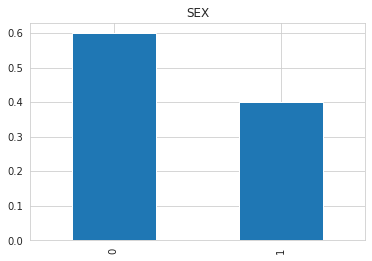

In [6]:
# Check!
data['sex'].value_counts(normalize=True).plot.bar()
plt.title('SEX')

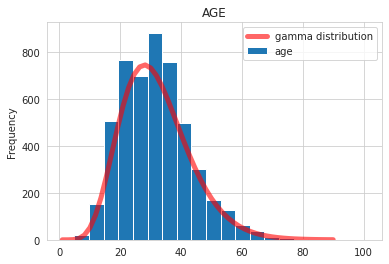

In [7]:
# Check!

# Data
data['age'].plot.hist(bins=20)

x = np.linspace(1,90)
# Theoretical distribution "aprox"
plt.plot(x, gamma.pdf(x, 8,0,4)*20000,'r-', lw=5, alpha=0.6, label='gamma distribution')

plt.title('AGE')
plt.legend()

In [8]:
print('Quantity by Class:')
print("---"*10)
print(data['output'].value_counts())

Quantity by Class:
------------------------------
1    3599
0    1401
Name: output, dtype: int64


Text(0.5, 1.0, 'Purchase')

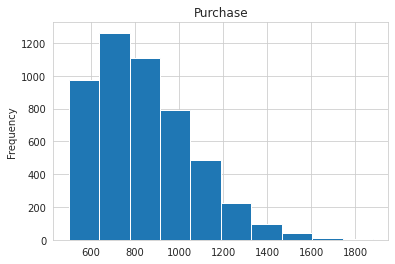

In [9]:
data['purchase'].plot.hist()
plt.title('Purchase')

## Balance de clases

El conjunto de datos generado con 5K puntos esta compuesto por "3599 casos para la clase 1" y "1401 casos para la clase 0", con un "ratio" aproximado de "2.3:1". Si bien la proporción entre las clases no esta balanceado, creo que no es lo suficientemente importante como para necesitar resolver el problemanecesitar aplicando metodos específicos. Como primer acercamiento los dejaré de lado.

Text(0.5, 1.0, 'Balance of Class')

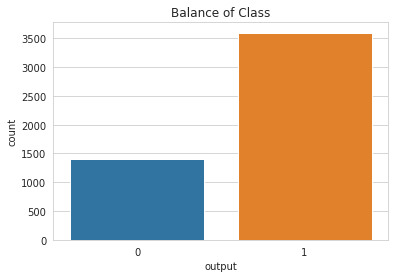

In [10]:
sns.countplot(data=data,x='output')
plt.title('Balance of Class')

Según lo visto hasta ahora la proporción de "Hembra" y "Macho" está relativamente equilibrada, en igual manera que lo esta la proporcion entre las clases "0" y "1". Sin embargo, como se puede ver en el siguiente grafico la distribucion entre ambos es muy diferente. las "Hembras" está más equilibrada en ambas clases respecto a "Macho", que en su mayoría pertenecen a la clase 1. El feature "sex" para "male" presenta una buena capacidad para separar las clases "0" y "1". 

Sin embargo cuando se tiene un feature con una importancia tan grande puede complicar el trabajo con las otras variables. Si pensamos en un modelo de árbol de decisión, luego de separar por "sex==male" el siguiente paso recibirá un problema desbalanceado. Si bien este desbalance que se generara requeriría de un poco de atención, por suerte  continua siendo pequeño. Un posible enfoque para mejorar en el futuro podría ser el uso de un modelo para cada sexo con un tratamiento para datos desequilibrados. 


Text(0.5, 1.0, 'Balance of Class by "sex"')

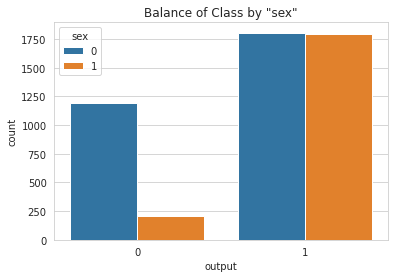

In [11]:
sns.countplot(data=data,x='output',hue='sex')
plt.title('Balance of Class by "sex"')

## Correlación de las variables


Las siguientes grillas de gráficos corresponden a la distribución de los casos, primero para "male" y luego para "female". 
En el caso de los "male" se observa como la superposición de las distribuciones para las clases "0" y "1" es muy grande, tanto para las variables "age" como para "purchase". Se observan diferencias entre ambas pero no muy grandes, lo que anticipa que las soluciones al problema serán de bajo rendimiento. 
Lo mismo ocurre para el caso de "mujeres" donde la superposición entre las distribuciones es casi completa. Se observan algunas diferencias cuando se comparan los mismos gráficos entre "hombre" y "mujer". 
En el caso del feature "age" es el más evidente, donde la distribución de la clase "0" para "hombres" no alcanza valores demasiado bajos de edad en comparación a "female".

Text(0.5, 0.98, 'Distribution of Cases for "Male" (sex=1)')

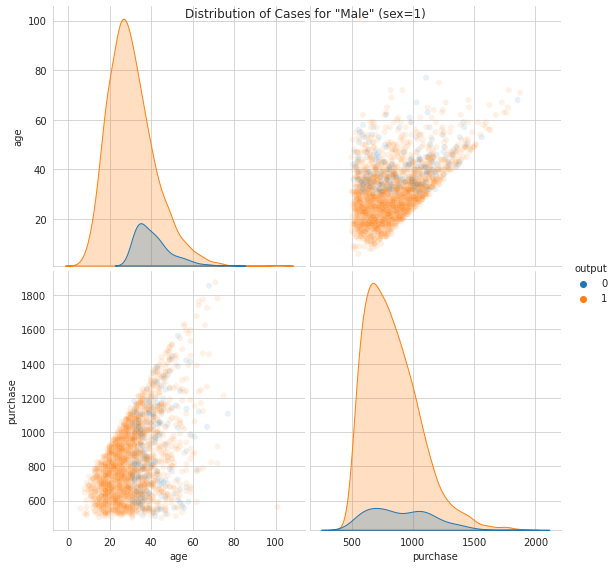

In [12]:
# Distribution of Cases for Male (sex=1)
g = sns.pairplot(data.loc[data['sex']==1], 
                 vars=['age','purchase'], 
                 hue="output", 
                 height=4,
                 plot_kws={'alpha':0.1})
g.fig.suptitle('Distribution of Cases for "Male" (sex=1)')

Text(0.5, 0.98, 'Distribution of Cases for "Female" (sex=0)')

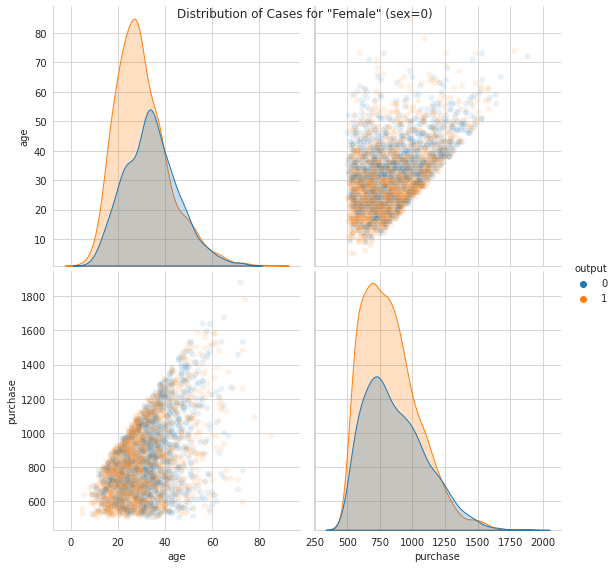

In [13]:
# Distribution of Cases for Female (sex=0)
g = sns.pairplot(data.loc[data['sex']==0], 
                 vars=['age','purchase'], 
                 hue="output", 
                 height=4,plot_kws={'alpha':0.1})
g.fig.suptitle('Distribution of Cases for "Female" (sex=0)')

De la gráfica de la matriz de correlación se puede ver que el feature "sex" tiene una correlación casi nula con "age" y "purchase", sin embargo los rasgos "age" y "purchase" están correlacionados con un valor significativo. De aquí podemos deducir que la implementación de un Modelo de Regresión Logística necesitará algún tipo de regularización.
De igual manera se puede ver que el feature que mas correlaciona con "output" corresponde a "sex", correlación que ya habiamos anticipado.


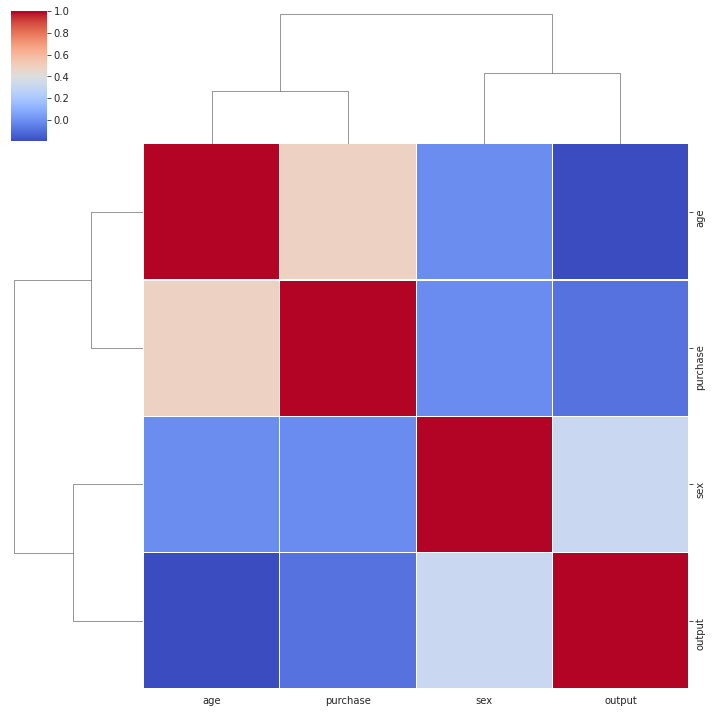

In [14]:
corr = data.corr()
sns.clustermap(corr, cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete')

# La construcción de los modelos

Antes de empezar a construir los modelos separaré el conjunto de datos en ``train`` y ``test``. El primero lo usaremos para el ajuste de los hiperparametros y entrenamiento del modelo, mientras que el segundo para la evaluación del mismo.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [16]:
X, y = data.drop(['output'], axis=1), data[['output']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Logistic Regression <a class="anchor" id="logreg"></a>

[Return to index...](#index)

### Preprocesamiento

El preprocesamiento de los datos cumple la función de preparan los datos para la ingesta por un modelo. 
Su objetivo es generar las condiciones para que el modelo pueda funcionar lo mejor posible con los datos disponibles.
El tipo de preprocesamiento que se le debe dar a los datos depende del tipo de variable que es, la distribución que posea, etcetera, pero especialmente depende del modelo con el que se piensa trabajar.
Existen muchas formas de preprocesamiento de los datos, pero en general, los algoritmos de aprendizaje se benefician de la normalización del conjunto de datos. Por ejemplo, los regularizadores "l1" y "l2" de los modelos lineales suponen que todas los features están centradas en torno a cero y tienen una varianza en el mismo orden. Si una característica tiene una varianza de órdenes de magnitud mayores que otras, podría dominar la función objetiva y hacer que el estimador no pueda aprender de otras características correctamente como se espera. Por ello, las variables numéricas "edad" y "compra" del conjunto de datos se procesan previamente con la función del StandardScaler antes de su utilización en el modelo. En el caso de la variable categórica "sexo" no necesito hacer nada porque ya tiene el formato de OneHotEncoding.

In [17]:
numeric_columns = ['age','purchase']
categoric_columns = ['sex']

numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns)],
                                 remainder='passthrough')

### Model

In [18]:

model = LogisticRegression(solver = 'liblinear',max_iter=1000)

### Pipeline

In order to define the flow of data from one stage to the other, I will use the `Pipeline` function.

In [19]:
pipeline = Pipeline(steps=[
    ('preprocessing',preprocessor),
    ('classificator',model)
])

### Grid Search

Grid Search in an Exhaustive search over all specified parameter values for an estimator. 


Logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other. Unfortunately variables "age" and "purchase" are correlated. For deal with this problem is necesary penalize correlated variables through some regularization term added to the loss funtion. In the model, hyperparameter `penalty` permit select between a family of them ("l1", "l2" and "elastic-net"). In the problem I will work only with "l1" and "l2". Regularization has another hiperparameter asociated `C` which regulates how strength is the penalty for the correlated variables. 


<b>Resume of Hyperparameters to use   in this work:</b>

* ``penalty`` : 
    Specify the regularization that is applied.

* ``C`` : 
    Inverse of regularization strength.

A continuación se definen los valores a explorar para cada hiperparametro. Como resultado se obtiene un total de 22 configuraciones diferentes.

In [20]:
lr_C =  [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,100,1000]
reg = ['l1','l2']

## defino los hyperparámetros que voy a recorrer
param_grid = [
  {'classificator__C':lr_C, 'classificator__penalty':reg}
]

If 

In [100]:
def count_models_to_train(param_grid):
  quantity = 1
  for param in param_grid[0].keys():
    quantity *= len(param_grid[0][param])
  return quantity

print(f'Quantity of configurations : {count_models_to_train(param_grid)}')

Quantity of configurations : 24


In [22]:
CV = 5

lr_search = GridSearchCV(pipeline, param_grid, 
                      cv=CV,return_train_score = True,
                      scoring = 'roc_auc').fit(X_train, y_train['output'].ravel())

### Best Model Found

After an exhaustive search over all specified hyperparameter values the best model found correspond to ``C=0.005`` and ``penalty='l1'``. But the range of values evaluates was huge in insignificant number of points, I just has a better idea respect to range of values where to search. It's posible iterate in a new Grid Search after analyze but for this example I will just leave it as a suggestion.

In [23]:
lr_search.best_estimator_['classificator']

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
results = pd.DataFrame(lr_search.cv_results_)

In [25]:
l1_results = results.loc[results.param_classificator__penalty=='l1']
l2_results = results.loc[results.param_classificator__penalty=='l2']

In [26]:
def plot_train_test(results, parameter, cv, color , label):
    
    param_C = results[f'param_classificator__{parameter}']
    
    perf_train = results['mean_train_score']
    std_train = results['std_train_score']*1.96/np.sqrt(cv)
    ylow_train =   perf_train - std_train
    yup_train = perf_train + std_train
    
    perf_test = results['mean_test_score']
    std_test = results['std_test_score']*1.96/np.sqrt(cv)
    ylow_test =   perf_test - std_test
    yup_test = perf_test + std_test
    
    fig, ax = plt.subplots(1)
    
    ax.plot(param_C,perf_train,color=color , label=f'{label}-train')
    ax.fill_between(param_C.astype(float), 
                    yup_train, 
                    ylow_train, 
                    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
    
    ax.plot(param_C,perf_test, color=color, linestyle='--', label=f'{label}-validation')
    ax.fill_between(param_C.astype(float), 
                    yup_test, 
                    ylow_test, 
                    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
    plt.xlabel(parameter)
    plt.ylabel('auc_roc')
    plt.legend()

Al observar la figura correspondiente a una regularización "L1" puede verse que para valores muy pequeños de "C" la performance del modelo es muy baja, incrementandose abruptamente a partir se cierto humbral. Para valores pequeños de "C" en una regularización "L1" corresponde a una penalización muy fuerte, y el efecto que se obtiene es la eliminación features correlacionados. Para el valor de ``C=0.005`` el modelo alcanza su valor mááximo de performance, y desde ese valor nos cambios que se observan no son muy significativos. Si tomamos en cuenta que para valores muy altos de "C" la penalización es muy pequeña aproximandose a un modelo sin regularización, vemos que las mejoras que se obtienen no son muy grandes. Otra cosa que se observa es que en ningún momento nuestro modelo realiza overfiting. Esto se entiende ya que un modelo de regresion logistica es un modelo demasiado simple.

(0.7, 0.77)

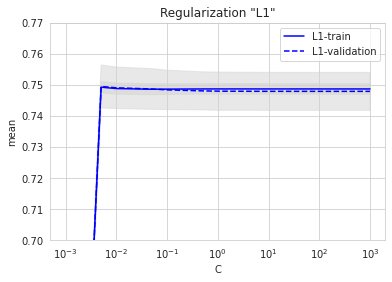

In [27]:
plot_train_test(l1_results, parameter='C', cv=CV,color='blue', label="L1")
plt.xscale('log')
plt.title('Regularization "L1"')
plt.ylim(0.70,0.77)

Al observar las curvas correspondiente a una regularizacion "L2" vemos similitudes y diferencias con las curva con regularización "L1". Para valores bajos de "C" la performance del modelo es baja, pero su comportamiento no es tan abrupto como en el caso anterior. Sin embargo, aqui no parece aparecer un valor maximo. Al contrario, parece comportarce monotonamente en todo el resto del espectro de valores de "C". 

(0.7, 0.77)

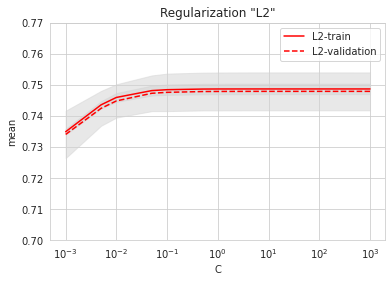

In [28]:
plot_train_test(l2_results, parameter='C', cv=CV,color='red', label="L2")
plt.title('Regularization "L2"')
plt.xscale('log')
plt.ylim(0.70,0.77)

## Random Forest 

### Preprocessing

Random Forest is a tree-based model and hence does not require feature scaling

### Model

In [139]:
model = RandomForestClassifier(random_state=SEED,max_features=None)

### Pipeline

If well in this situation I don't need really use pipeline to define the flow of data because there is just one stage, I prefer use it because is more easy to modificate if I want do it in future.

In [115]:
pipeline = Pipeline(steps=[
    ('classificator',model)
])

### Grid Search


Random Forest es un modelo basado en árboles y por lo tanto muchos hiperparámetros están relacionados con un solo árbol. Sin embargo, la fuerza de este modelo es que también funciona con el concepto de conjunto, es decir, muchos árboles diferentes. Para generar estos conjuntos, el modelo ademas utiliza otros hiperparámetros. La cantidad de hiperparametros que contiene este modelo lo hacen de una complejidad mayor a uno de regresion logistica. La cantidad de configuraciones posibles que se generan con unos pocos valores por hiperparametro crece enormemente y con ello el tiempo de computo. Comienza a ser prudente considerar otras estrategias para la exploración de configuraciones posibles. 
Para explorar este modelo propongo una primera exploración con un hiperparametro que controle la profundida de cada arbol ``(max_depth)``. Este hiperparametro tiene la capacidad de controlar fuertemente la complejidad del modelo y alejarnos del overfiting. Por otro lado propongo tambien explorar el numero total de arboles, o lo que es lo mismo el numero de estimadores ``(n_estimators)``. Este parametro tiende a mejorar la performance y a la generalización del modelo.


<b>Resume of Hyperparameters to use in this work:</b>

* ``n_estimators`` : 
    The number of trees in the forest.

* ``max_depth`` : 
    The maximum depth of the tree.

A continuación se definen los valores a explorar para cada hiperparametro. Como resultado se obtiene un total de 24 configuraciones diferentes.

In [130]:
# The number of trees in the forest.
n_estimators = np.array([1, 5, 10, 50, 100, 500])
# The maximum depth of the tree.
max_depth = [1,2,3,4]

param_grid = [
  {'classificator__n_estimators':n_estimators,
   'classificator__max_depth':max_depth}
 ]
 
 print(f'Quantity of configurations : {count_models_to_train(param_grid)}')

In [132]:
CV = 5
rf_search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                      scoring = 'roc_auc').fit(X_train, y_train['output'].ravel())

### Best Model

Como resultado de la busqueda exaustiva en toda la grilla de valores de hiperparametros se obtiene que el mejor modelo hallado corresponde a ``max_depth=2`` y ``n_estimators=100``. Situandome en la mejor configuracion de hiperparametros hallada voy a ver como se comporta la performance del modelo al variar los hiperparametros de a uno.

In [133]:
best_params = rf_search.best_estimator_['classificator'].get_params()
best_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [134]:
results = pd.DataFrame(rf_search.cv_results_)

Text(0.5, 1.0, 'Max-Depth (best = 2)')

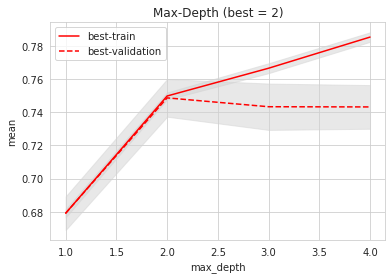

In [138]:
max_depth_results = results.loc[(results['param_classificator__n_estimators']==best_params['n_estimators'])]
plot_train_test(max_depth_results, parameter='max_depth', cv=CV, color='red',label='best')
plt.title('Max-Depth (best = 2)')

(0.72, 0.78)

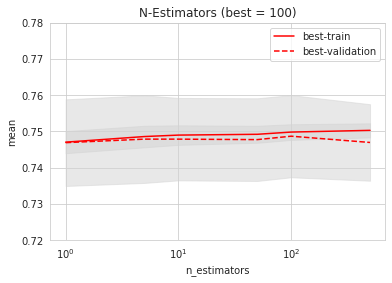

In [136]:
n_estim_result = results.loc[(results['param_classificator__max_depth']==best_params['max_depth'])]

plot_train_test(n_estim_result, parameter='n_estimators', cv=CV, color='red',label='best')
plt.xscale('log')
plt.title('N-Estimators (best = 100)')
plt.ylim(0.72,0.78)

## Evaluations <a class="anchor" id="evals"></a>

In [125]:
from sklearn.metrics import roc_curve, auc

In [126]:
# Linear Regression
lr_best_model = lr_search.best_estimator_
y_pred_lr = lr_best_model.predict_proba(X_test)

# Random Forest
rf_best_model = rf_search.best_estimator_
y_pred_rf = rf_best_model.predict_proba(X_test)

In [127]:
def plot_roc_curve(y_test, y_pred, name):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1],)
  auc_roc = auc(fpr, tpr).
  plt.plot(fpr, tpr,lw=2, label= f'{name} (area = {round(auc_roc, 3)})')
  plt.plot([0, 1], [0, 1], color='darkred', lw=2, linestyle='--')
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")

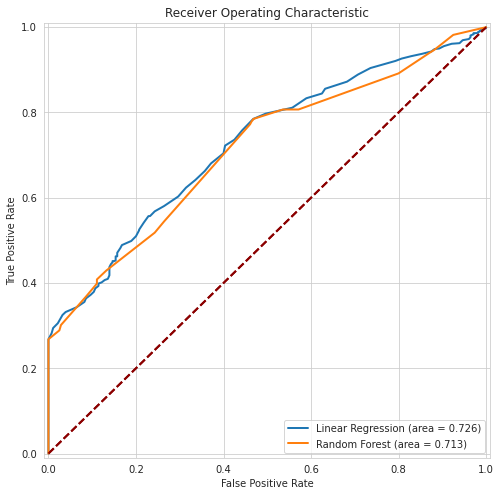

In [128]:
plt.figure(figsize=(8,8))
plot_roc_curve(y_test,y_pred_lr,'Linear Regression')
plot_roc_curve(y_test,y_pred_rf,'Random Forest')